
Dropped columns due to missing values (35):
 - (E)-2-Pentenal Area
 - (E)-Linalool oxide Area
 - 1-Octen-3-ol Area
 - 2-Acetylpyrrole Area
 - 2-Ethylfuran Area
 - 2-Hexanone Area
 - 2-Methylpentan-2-ol Area
 - 2-Pentanol Area
 - 3-Hexanone Area
 - 3-Methyl-2-butanone Area
 - 3-Methyl-3-butenyl acetate Area
 - 6-Methoxyeugenol Area
 - Acetal Area
 - Allyl isothiocyanate Area
 - Butyl acetate Area
 - Butyric acid Area
 - Dihydrocarveol Area
 - Ethyl 2-methylbutyrate Area
 - Ethyl isobutyrate Area
 - Ethyl lactate Area
 - Ethyl vinyl ketone Area
 - Geranyl isovalerate Area
 - Isobutyric acid Area
 - Isopropyl hexanoate Area
 - Methyl 2-methylbutyrate Area
 - Methyl hexanoate Area
 - Methyl isobutyl ketone Area
 - Methyl isovalerate Area
 - Neodihydrocarveol Area
 - Propanoic acid Area
 - Propyl acetate Area
 - Tetrahydrothiophene Area
 - alpha-Pinene Area
 - beta-Pinene Area
 - cis-3-Hexen-1-ol Area
Components: 1 | Accuracy: 0.08
Components: 2 | Accuracy: 1.00
Components: 3 | Accuracy: 1

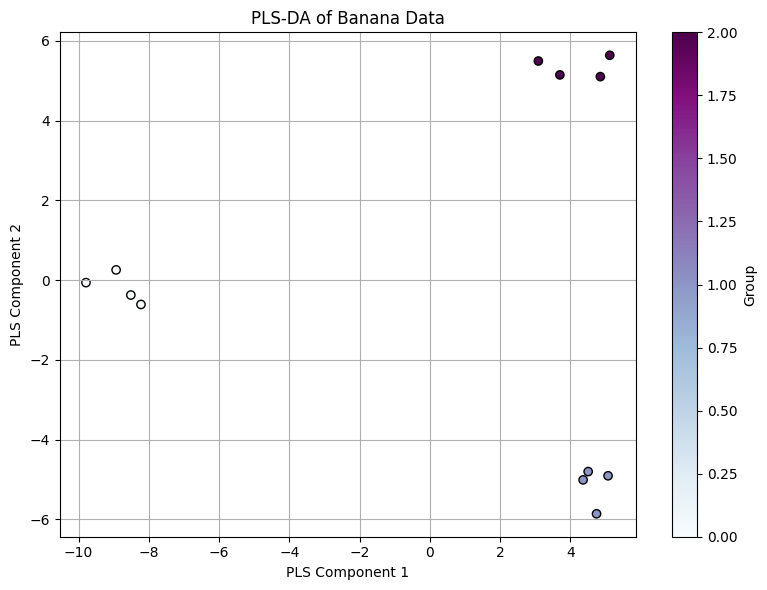

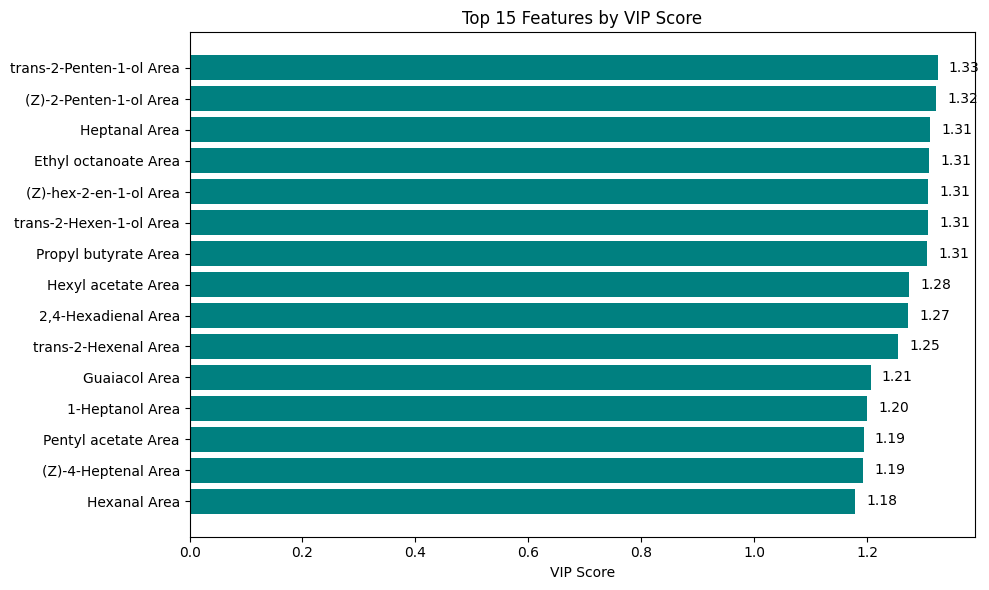

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
 

# ----------------------
# Step 1: Load and clean
# ----------------------

'''
Choice here between filled data or non-filled 
'''
# Load the dataset (group impute, nans filled with pseudocount)
#df = pd.read_csv("badata_imputed_filled.csv")

df = pd.read_csv('badata_imputed.csv') #this one imputes median of category per column if available but has many NaNs
'''
pick the preproces file carefully
'''

df = df.drop(columns=[df.columns[0]])  # Drop index

# Separate labels(y) and features(X)
y_raw = df['Groups']
X_raw = df.drop(columns=['Groups'])

# Identify and drop columns with any missing values
missing_cols = X_raw.columns[X_raw.isna().any()].tolist()
print(f"\nDropped columns due to missing values ({len(missing_cols)}):")
for col in missing_cols:
    print(f" - {col}")

X = X_raw.drop(columns=missing_cols)


# use one hot encode to change ripeness to numerical values
onehot = OneHotEncoder(sparse_output=False)
y= onehot.fit_transform(y_raw.values.reshape(-1, 1))


X_log = np.log10(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)
 

# tests best number of components for plsreg 
for n in range(1, 6):
    pls = PLSRegression(n_components=n)
    y_pred = cross_val_predict(pls, X_scaled, y, cv=5)
    acc = accuracy_score(np.argmax(y, axis=1), np.argmax(y_pred, axis=1))
    print(f"Components: {n} | Accuracy: {acc:.2f}")

# Apply PLS-DA
pls = PLSRegression(n_components=2)
X_scores, _ = pls.fit_transform(X_scaled, y)
 
# Cross-validation
y_pred = cross_val_predict(pls, X_scaled, y, cv=5)
y_true_labels = np.argmax(y, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f'Cross-validated accuracy: {accuracy:.2f}')

# Plot
color_map = {'Green': 0, 'Ripe': 1, 'Overripe': 2}
colors = y_raw.map(color_map)

plt.figure(figsize=(8, 6))
plt.scatter(X_scores[:, 0], X_scores[:, 1], c=colors, cmap='BuPu', edgecolor='k')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS-DA of Banana Data')
plt.colorbar(label='Group')
plt.grid(True)
plt.tight_layout()
plt.show()


# VIP score calculation
def calculate_vip(pls_model, X_scaled, y_onehot):
    t = pls_model.x_scores_
    w = pls_model.x_weights_
    q = pls_model.y_loadings_

    p, h = w.shape
    s = np.zeros((h,))
    for i in range(h):
         s[i] = np.sum((t[:, i] ** 2) * np.sum(q[:, i] ** 2))

    total_s = np.sum(s)
    vip = np.zeros((p,))
    for i in range(p):
        weight = np.array([(w[i, j] ** 2) * s[j] for j in range(h)])
        vip[i] = np.sqrt(p * np.sum(weight) / total_s)
    return vip

vip_scores = calculate_vip(pls, X_scaled, y)
vip_df = pd.DataFrame({'Feature': X.columns, 'VIP': vip_scores})
vip_df_sorted = vip_df.sort_values(by='VIP', ascending=False)

# Plot top 15 VIP features
top_n = 15
plt.figure(figsize=(10, 6))
#plt.barh(vip_df_sorted['Feature'].head(top_n)[::-1], vip_df_sorted['VIP'].head(top_n)[::-1], color='teal')


top_vips = vip_df_sorted.head(top_n)
colors = ['teal' if v > 1 else 'lightgray' for v in top_vips['VIP']]

plt.barh(top_vips['Feature'][::-1], top_vips['VIP'][::-1], color=colors)
for i, v in enumerate(top_vips['VIP'][::-1]):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')



plt.xlabel('VIP Score')
plt.title(f'Top {top_n} Features by VIP Score')
plt.tight_layout()
plt.show()




Dropped 35 columns with NaNs.

Cross-validated accuracy by number of PLS components:
Components: 1, Accuracy: 0.5833
Components: 2, Accuracy: 1.0000
Components: 3, Accuracy: 1.0000
Components: 4, Accuracy: 1.0000
Components: 5, Accuracy: 1.0000
Components: 6, Accuracy: 1.0000

Final CV Accuracy (2 components): 1.00
              precision    recall  f1-score   support

       Green       1.00      1.00      1.00         4
    Overripe       1.00      1.00      1.00         4
        Ripe       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


Sanity check (shuffled labels) accuracy: 0.33


/var/folders/_4/f_rgwft14s14_j1xnpz_zn7c0000gn/T/ipykernel_24620/4162600321.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_classes))


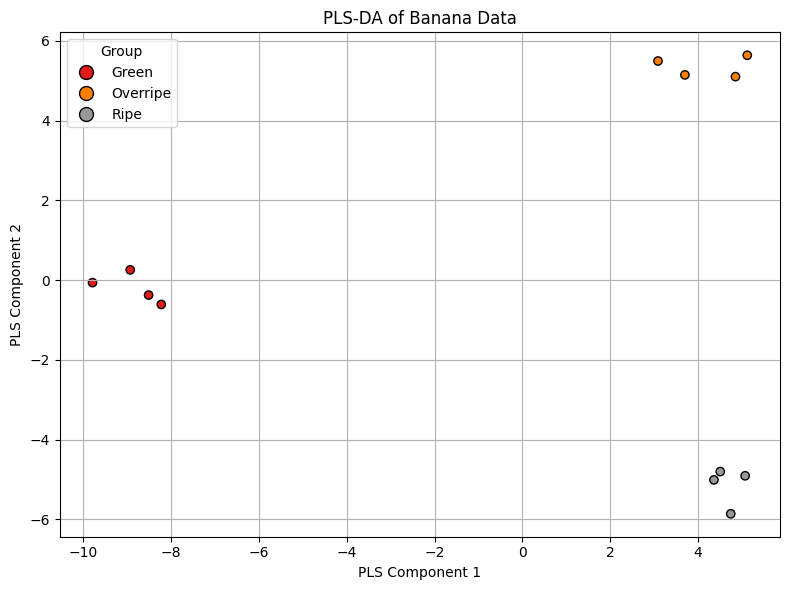

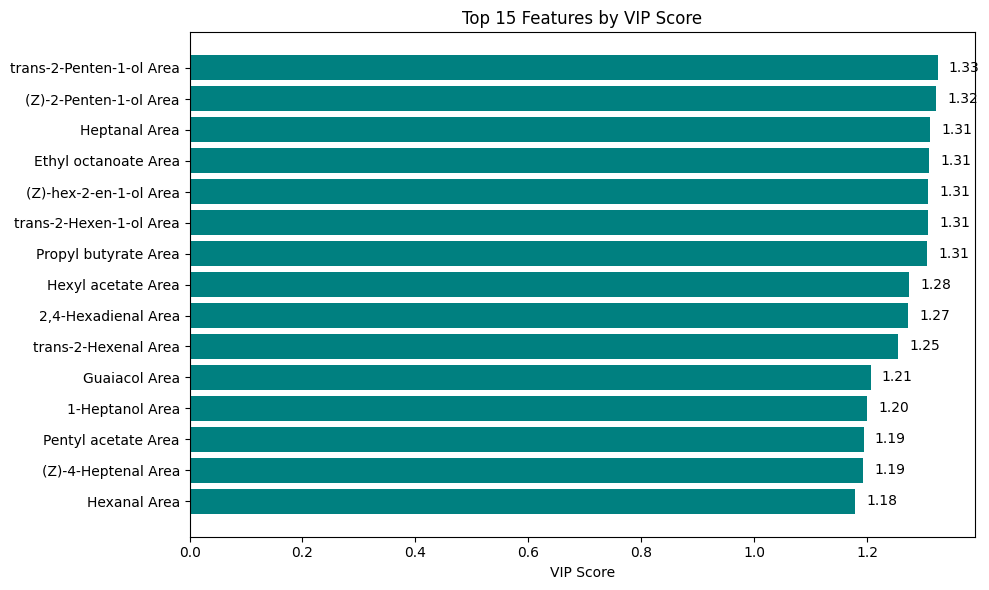

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn import __version__ as sklearn_version
from packaging import version

# ----------------------
# Step 1: Load and clean
# ----------------------

df = pd.read_csv('badata_imputed.csv')
df = df.drop(columns=[df.columns[0]])  # drop unnamed index column

# Separate features and target
y_raw = df['Groups']
X_raw = df.drop(columns=['Groups'])

# Drop any columns with missing values
missing_cols = X_raw.columns[X_raw.isna().any()]
X_clean = X_raw.drop(columns=missing_cols)
print(f"Dropped {len(missing_cols)} columns with NaNs.")

# Log-transform (assumes all values > 0)
X_log = np.log10(X_clean)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# Version-safe OneHotEncoder
if version.parse(sklearn_version) >= version.parse("1.2"):
    encoder = OneHotEncoder(sparse_output=False)
else:
    encoder = OneHotEncoder(sparse=False)

y = encoder.fit_transform(y_raw.values.reshape(-1, 1))
class_labels = encoder.categories_[0]
y_labels = np.argmax(y, axis=1)

# ------------------------------
# Step 2: Cross-validation test
# ------------------------------

print("\nCross-validated accuracy by number of PLS components:")
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

for n_components in range(1, 7):
    y_pred_all = np.zeros_like(y)
    
    for train_idx, test_idx in skf.split(X_scaled, y_labels):
        pls = PLSRegression(n_components=n_components)
        pls.fit(X_scaled[train_idx], y[train_idx])
        y_pred_all[test_idx] = pls.predict(X_scaled[test_idx])
    
    y_pred_labels = np.argmax(y_pred_all, axis=1)
    acc = accuracy_score(y_labels, y_pred_labels)
    print(f"Components: {n_components}, Accuracy: {acc:.4f}")

# ------------------------------
# Step 3: Fit final model (2 comps)
# ------------------------------

pls = PLSRegression(n_components=2)
X_scores, _ = pls.fit_transform(X_scaled, y)

# Use regular KFold for one-hot regression predictions
kf = KFold(n_splits=3, shuffle=True, random_state=1)
y_pred_probs = cross_val_predict(pls, X_scaled, y, cv=kf)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_labels, y_pred_labels)
print(f"\nFinal CV Accuracy (2 components): {acc:.2f}")
print(classification_report(y_labels, y_pred_labels, target_names=class_labels))

# ------------------------------
# Step 4: Sanity check (shuffled labels)
# ------------------------------

y_labels_shuffled = shuffle(y_labels, random_state=42)
y_shuffled = np.eye(len(class_labels))[y_labels_shuffled]

y_pred_shuffled = cross_val_predict(pls, X_scaled, y_shuffled, cv=kf)
acc_shuffled = accuracy_score(y_labels_shuffled, np.argmax(y_pred_shuffled, axis=1))
print(f"\nSanity check (shuffled labels) accuracy: {acc_shuffled:.2f}")

# ------------------------------
# Step 5: PLS-DA score plot
# ------------------------------

# Dynamic color map
unique_classes = sorted(y_raw.unique())
color_map = {label: i for i, label in enumerate(unique_classes)}
colors = y_raw.map(color_map)
cmap = plt.cm.get_cmap('Set1', len(unique_classes))

plt.figure(figsize=(8, 6))
plt.scatter(X_scores[:, 0], X_scores[:, 1], c=colors, cmap=cmap, edgecolor='k')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS-DA of Banana Data')

# Legend
handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=cmap(i),
                      label=label, markersize=10, markeredgecolor='k')
           for label, i in color_map.items()]
plt.legend(handles=handles, title='Group')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Step 6: VIP score calculation
# ------------------------------

def calculate_vip(pls_model, X_scaled, y_onehot):
    t = pls_model.x_scores_
    w = pls_model.x_weights_
    q = pls_model.y_loadings_

    p, h = w.shape
    s = np.zeros(h)
    for i in range(h):
        s[i] = np.sum((t[:, i] ** 2) * np.sum(q[:, i] ** 2))

    total_s = np.sum(s)
    vip = np.zeros(p)
    for i in range(p):
        weight = np.array([(w[i, j] ** 2) * s[j] for j in range(h)])
        vip[i] = np.sqrt(p * np.sum(weight) / total_s)
    return vip

vip_scores = calculate_vip(pls, X_scaled, y)
vip_df = pd.DataFrame({'Feature': X_clean.columns, 'VIP': vip_scores})
vip_df_sorted = vip_df.sort_values(by='VIP', ascending=False)

# ------------------------------
# Step 7: VIP bar plot
# ------------------------------

top_n = 15
top_vips = vip_df_sorted.head(top_n)
vip_colors = ['teal' if v > 1 else 'lightgray' for v in top_vips['VIP']]

plt.figure(figsize=(10, 6))
plt.barh(top_vips['Feature'][::-1], top_vips['VIP'][::-1], color=vip_colors)
for i, v in enumerate(top_vips['VIP'][::-1]):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')
plt.xlabel('VIP Score')
plt.title(f'Top {top_n} Features by VIP Score')
plt.tight_layout()
plt.show()
